# Building a predictive model of temperature synchronization in Neurospora Crassa
Nearly all organisms have an internal clock.
Here I build a predictive model using ordinary differential equations to analyze the clock properties of a common model organism (the fungus Neurospora Crassa). To do this, I use a previously published model and add some features to specifically adress the question how temperature might influence the clock.
First, lets implement the model equations.

In [1]:
### load packages 
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.signal import argrelextrema
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MultipleLocator
import matplotlib.collections as collections
import string

%matplotlib inline

In [2]:
### implement biological model Hong et al 2008 

### dictionary of parameters

### rate constants per hour
rate = {
    'k1'    : 1.8,
    'k2'    : 1.8,
    'k3'    : 0.05,
    'k4'    : 0.23,
    'k5'    : 0.27,
    'k6'    : 0.07,
    'k7'    : 0.5,
    'k8'    : 0.8,
    'k9'    : 40.0,
    'k10'   : 0.3,
    'k11'   : 0.05,
    'k12'   : 0.02,
    'k13'   : 50.0,
    'k14'   : 1.0,
    'k15'   : 8.0,
    'K'     : 1.25,
    'K2'    : 1.0
}

### define forcing function
def ztan(t,T,kappa,z0, s=10):
    pi = np.pi
    om = 2*pi/T
    mu = pi/(om*np.sin(kappa*pi))
    cos1 = np.cos(om*t)
    cos2 = np.cos(kappa*pi)
    out = 1+2*z0*((1/pi)*np.arctan(s*mu*(cos1-cos2)))
    return out

### define ODE clock function

def clock(state, t, rate,T=20,kappa =.5,z0=.1, forcing = False):
        ### purpose:simulate Hong et al 2008 model for neuropora clock


        ### define state vector

        frq_mrna    = state[0]
        frq_c       = state[1]
        frq_n       = state[2]
        wc1_mrna    = state[3]
        wc1_c       = state[4]
        wc1_n       = state[5]
        frq_n_wc1_n = state[6]
        
        forcing_term = 1
        if forcing == True:
            forcing_term = ztan(t,T,kappa,z0)
        ###  ODEs Hong et al 2008
        ### letzter summand unklar bei dtfrqmrna
        
        dt_frq_mrna     = (forcing_term*rate['k1'] * (wc1_n**2) / (rate['K'] + (wc1_n**2))) - (rate['k4'] * frq_mrna) 
        dt_frq_c        = rate['k2'] * frq_mrna - ((rate['k3'] + rate['k5']) * frq_c)
        dt_frq_n        = (rate['k3'] * frq_c) + (rate['k14'] * frq_n_wc1_n) - (frq_n * (rate['k6'] + (rate['k13'] * wc1_n)))
        dt_wc1_mrna     = rate['k7'] - (rate['k10'] * wc1_mrna)
        dt_wc1_c        = (rate['k8'] * frq_c * wc1_mrna / (rate['K2'] + frq_c)) - ((rate['k9'] + rate['k11']) * wc1_c)
        dt_wc1_n        = (rate['k9'] * wc1_c) - (wc1_n * (rate['k12'] + (rate['k13'] * frq_n))) + (rate['k14'] * frq_n_wc1_n)
        dt_frq_n_wc1_n  = rate['k13'] * frq_n * wc1_n - ((rate['k14'] + rate['k15']) * frq_n_wc1_n)
        
        ### derivatives
        
        dt_state = [dt_frq_mrna,
                    dt_frq_c,
                    dt_frq_n,
                    dt_wc1_mrna,
                    dt_wc1_c,
                    dt_wc1_n,
                    dt_frq_n_wc1_n]
        
        return dt_state

Now for the interesting part: lets solve the equations and see what the clock model does! To solve the equations, I use the odeint function from the scipy library.

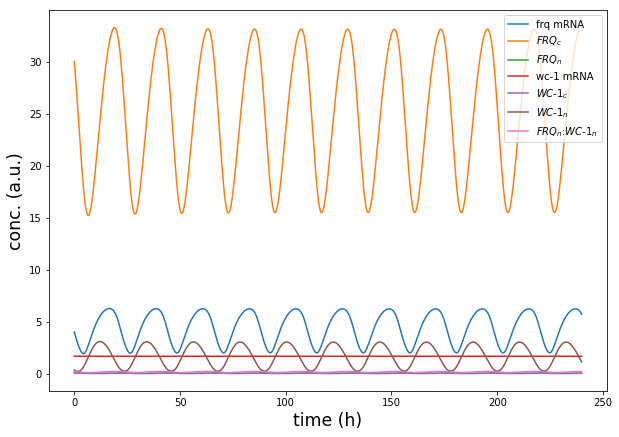

In [3]:
### set initial conditions for each ODE 

frq_mrna0    = 4.0
frq_c0       = 30.0
frq_n0       = 0.1
wc1_mrna0    = (0.5 / 0.3)
wc1_c0       = 0.03225
wc1_n0       = 0.35
frq_n_wc1_n0 = 0.18

state0 = [frq_mrna0,
          frq_c0,
          frq_n0,
          wc1_mrna0,
          wc1_c0,
          wc1_n0,
          frq_n_wc1_n0]

### set time to integrate

t      = np.arange(0,240,0.1)

### set variable names

state_names = ["frq mRNA","$FRQ_c$","$FRQ_n$","wc-1 mRNA","$WC$-$1_c$",
               "$WC$-$1_n$","$FRQ_n$:$WC$-$1_n$"]

### run simulation
state = odeint(clock,state0,t,args=(rate,)) 

fig, ax = plt.subplots(figsize = (10,7))

ax.plot(t,state)
ax.set_xlabel("time (h)", fontsize= 'xx-large')
ax.set_ylabel("conc. (a.u.)", fontsize= 'xx-large')
ax.legend(state_names,loc='upper right')

plt.show()

Okay, looks as if some things are oscillating which is what we want for a clock (its an oscillator just like a pendulum).
However, there are some proteins that are not well visualized if all variables are plotted together. So lets zoom in.

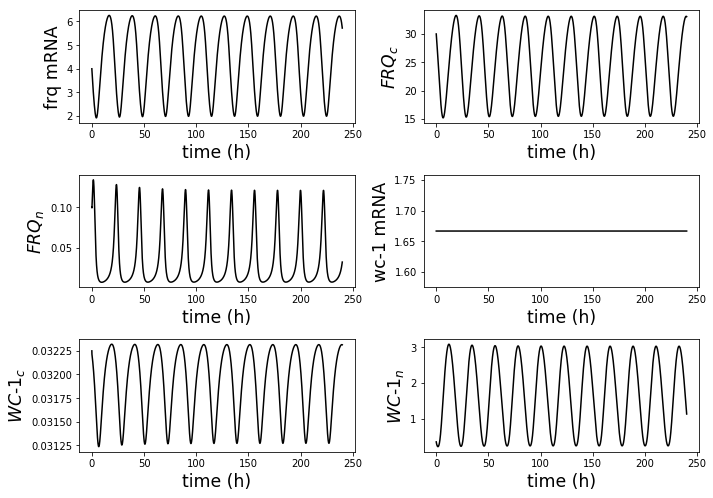

In [4]:
###plot figure 
fig, axes = plt.subplots(3,2,figsize = (10,7))
ax = axes.flatten()
for i in range(6):
    ax[i].plot(t,state[:,i],"k")
    ax[i].set_xlabel("time (h)", fontsize= 'xx-large')
    ax[i].set_ylabel(state_names[i], fontsize= 'xx-large')
    
plt.tight_layout()
plt.show()

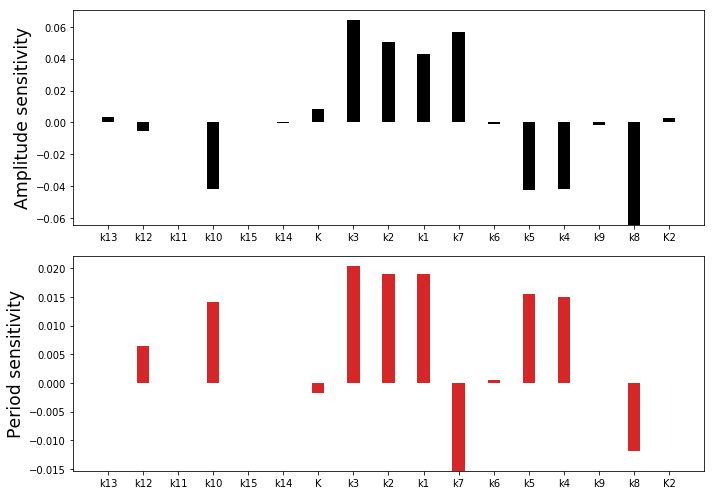

In [5]:
### lets first define a function to calculate the amplitude and the period 
params = [1.1,0.9,1]

amp_list=[[],[],[]]
per_list=[[],[],[]]

for idx,x in enumerate(params):
        
    for key in rate:
        """
        for each parameter in model, change its value +-10% and calculate amplitudes,
        periods and phase for each model variable. store everything in a nested dict
        that contains the parameter as main key 
        """
        
        ### copy the original rate dictionary
        params_dict = rate.copy()

        #### change parameter values in copied dicts
        params_dict[key] = params_dict[key] * x
    
        ### run simulation with new parameters
        state = odeint(clock,state0,t,args=(params_dict,))
        
        ### remove transient
        sp = state[int(-(10*50*22)):,1]
    
        t = t[int(-(10*50*22)):]
        
        maxima_indices = argrelextrema(sp, np.greater)[0]
        minima_indices = argrelextrema(sp, np.less)[0]
        
        maxima = sp[maxima_indices]
        minima = sp[minima_indices]
        
        amp = (maxima[0]-minima[0])/2
        period = np.mean(np.diff(maxima_indices))/10
        
        amp_list[idx].append(amp)
        per_list[idx].append(period)
        
amp_arr = np.asarray(amp_list)
per_arr = np.asarray(per_list)

amp_pos_coeff = (amp_arr[0]-amp_arr[2])/amp_arr[2]
amp_neg_coeff = (amp_arr[1]-amp_arr[2])/amp_arr[2]

per_pos_coeff = (per_arr[2]-per_arr[0])/per_arr[2]

width = 0.35
N = np.arange(len(amp_pos_coeff))

fig, axes = plt.subplots(2,1, figsize = (10,7))
ax = axes.flatten()
ax[0].bar(N, amp_pos_coeff, width, color='k')
ax[1].bar(N, per_pos_coeff, width, color='tab:red')

ax[0].set_xticks(N)
ax[1].set_xticks(N)

ax[0].set_xticklabels(rate.keys())
ax[1].set_xticklabels(rate.keys())

ax[0].set_ylabel("Amplitude sensitivity", fontsize = "xx-large")
ax[1].set_ylabel("Period sensitivity", fontsize = "xx-large")

plt.tight_layout()
### sensitivity analysis is indeed missing

The sensitivity is important because now we know which parameters to tweak in order to affect the model behavior.
I choose to periodically modulate the k1 parameter to model the effect of temperature. There are a number of ways to implement a forcing signal using simple sine/cosine functions, heavyside step functions and more. Here, I use an artcan function.

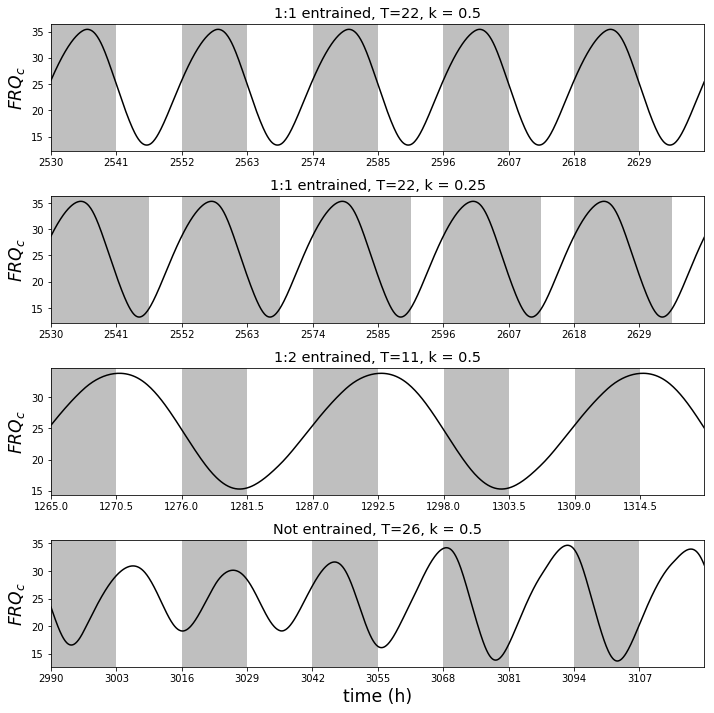

In [6]:
### periodic forcing function 
### plot with forcing strenghts
times =[22.0,22.0,11.0,26.0]

periods = [0.5,0.75,0.5,0.5]

fig, axes = plt.subplots(4,1,figsize = (10,10))

ax = axes.flatten()

for i in range(len(times)):
    
    T=times[i]
    kappa=periods[i]
    warm_period = T*kappa
    
    t = np.arange(0,120*T,0.1)
    state = odeint(clock,state0,t,args=(rate,T,kappa,0.07,True))
    trace = state[int(-(50*T)):,1]
    t = t[int(-(50*T)):]
    
    ax[i].plot(t,trace,"k")
    ax[i].set_xlim(t[0], t[-1])
    ax[i].set_xticks(np.arange(int(t[0]), int(t[-1]), T/2))
    #ax2.set_xticks(np.arange(0, 1200, 12.0))
    collection = collections.BrokenBarHCollection.span_where(
            t, ymin=100, ymax=-100, where= ((t % T) <= warm_period), facecolor='gray', alpha=0.5)
    ax[i].add_collection(collection)
    ax[i].set_ylabel("$FRQ_c$", fontsize = "xx-large")

ax[0].set_title("1:1 entrained, T=22, k = 0.5", fontsize = "x-large")
ax[1].set_title("1:1 entrained, T=22, k = 0.25", fontsize = "x-large")
ax[2].set_title("1:2 entrained, T=11, k = 0.5", fontsize = "x-large")
ax[3].set_title("Not entrained, T=26, k = 0.5", fontsize = "x-large")
ax[3].set_xlabel("time (h)", fontsize = "xx-large")

plt.tight_layout()

I added a function that continously perturbs the system. Remember your childhood days where you were on a swing and your parents pushed you to give you accelaration? Its similar (of note for the attentive reader: no, not really because the model here is a limit cycle oscillator not a harmonic oscillator but lets not get into details). What you can see is that for small forcing strengths the oscillation is not completely in line with the temperature rhythm but for a higher forcing strength the period of the oscillation and the period of the forcing rhythm are aligned.
T indicates forcing period, k indicates ratio of white and black areas (ratio of warm to cold signal).

### Data analysis

In [7]:
### here come coniditation figure and fourier figure

### Dynamic behavior
To study a dynamical system it makes often more sense to look at the system in phase space. A normal oscillation of this model then corresponds to what is called a limit cycle. However, if forcing is applied it may well happen that the system does not precisely describe a cycle but is instead oscillating on a torus (this is called quasiperiodic oscillation and it might be what you saw in the previous figure for low forcing strenghts). In this case, the two oscillations of the internal rhythm and the external rhythm do not exactly align). A torus is a strange word but it looks pretty cool and it resembles a donut!

To push this a little further it might also happen that for very high forcing periods the systems behavior becomes chaotic (maybe imaginge that your parents are pushing you a little too hard on the swing so that you go all the way around and then imaginge the same thing for a more complex oscillator if you can :) ). In any case, there is some structure in chaos and it can be visualized in phase space. One particular structure is the strange attractor which we might see in the figure below.

There is a lot more to dynamical systems (synchronization, bifurcations, transients and so on) - if you are interested, have a look at my MSc thesis and at the notebook where I compare this system to our data.

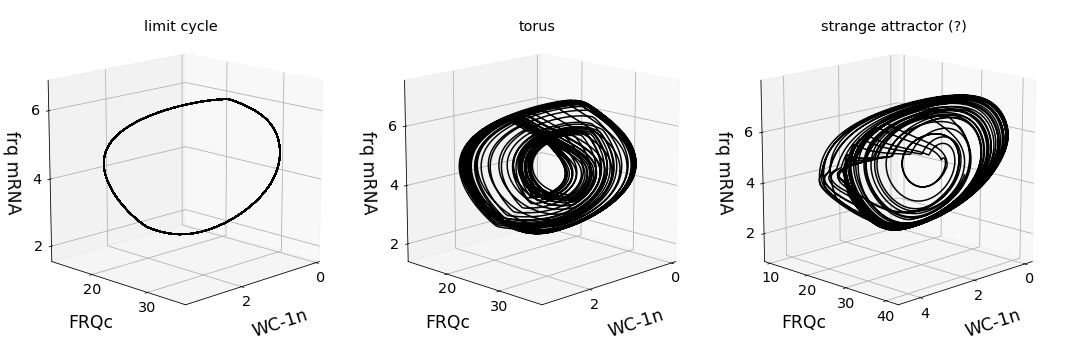

In [8]:
### simulate chaos for increasing forcing strength 
zeitgeber_strength = np.array([.1,.3,.23])
times = [21.0,16.5,27.9]
periods = [0.5,0.5,0.75]

t = np.arange(0,100*T,0.1)

frq = []
FRQ = []
wc = []
for i in range(len(times)):
    T = times[i]
    kappa = periods[i]
    z= zeitgeber_strength[i]
    
    state = odeint(clock,state0,t,args=(rate,T,kappa,z,True))   
    s1 = state[int(-(10*50*T)):,:]

    
    t = t[int(-(10*50*T)):]   

     
    frq1 = s1[:,0]
    FRQ1 = s1[:,1]
    wc1   = s1[:,5]

    frq.append(frq1)
    FRQ.append(FRQ1)
    wc.append(wc1)   

        ### for these 50 T cycles, keep only every  Tth entry

azim = 45
elev = 15

def plotstyle(axes):
    for ax in axes:
        ax.set_xlabel("WC-1n", fontsize = 'xx-large',labelpad=10)
        ax.set_ylabel("FRQc", fontsize = 'xx-large',labelpad=10)
        ax.set_zlabel("frq mRNA", fontsize = 'xx-large')
        ax.tick_params(labelsize= 'x-large')
        ax.xaxis.set_major_locator(MultipleLocator(2))
        ax.yaxis.set_major_locator(MultipleLocator(10))
        ax.zaxis.set_major_locator(MultipleLocator(2))
        
        [t.set_va('center') for t in ax.get_yticklabels()]
        [t.set_ha('left') for t in ax.get_yticklabels()]
        [t.set_va('center') for t in ax.get_xticklabels()]
        [t.set_ha('right') for t in ax.get_xticklabels()]
        [t.set_va('center') for t in ax.get_zticklabels()]
        [t.set_ha('left') for t in ax.get_zticklabels()]

###plot figure
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131, projection='3d')
ax.plot(wc[0],FRQ[0],frq[0],'k')
ax.view_init(elev = elev,azim=45)
ax.set_title("limit cycle", fontsize = "x-large")

ax1 =fig.add_subplot(132, projection = '3d')
ax1.plot(wc[1],FRQ[1],frq[1],'k')
ax1.view_init(elev = elev,azim=45)
ax1.set_title("torus", fontsize = "x-large")

ax2 =fig.add_subplot(133, projection = '3d')
ax2.plot(wc[2],FRQ[2],frq[2],'k')
ax2.view_init(elev = elev,azim=45)
ax2.set_title("strange attractor (?)", fontsize = "x-large")

plotstyle(axes=[ax,ax1,ax2])
plt.tight_layout()